In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from PIL import Image
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

from datetime import datetime
import cv2

# Utility functions

In [3]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    im = Image.open(filename)
    bm = im.convert('RGB')
    im.close()
    im=bm
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    im.close()
    bm.close()
    resaved_im.close()
    del filename
    del resaved_filename
    del im
    del bm
    del resaved_im
    del extrema
    del max_diff
    del scale
    return ela_im

def build_image_list(path_to_image, label, images):
    for file in tqdm(os.listdir(path_to_image)):
        try:
            if file.endswith('jpg') or file.endswith('JPG') or file.endswith('jpeg') or file.endswith('JPEG'):
                if int(os.stat(path_to_image + file).st_size) > 10000:
                    line = path_to_image + file  + ',' + label + '\n'
                    images.append(line)
        except:
            print(path_to_image + file)
    return images
    


# Data Preparation

### Path to list of original and tampered documents specific to your needs

In [4]:
custom_path_original = 'images/training/original/'
custom_path_tampered = 'images/training/forged/'

### Training dataset name

In [5]:
training_data_set = 'dataset.csv'

### Build image list for training

In [6]:
images = []
images = build_image_list(custom_path_original, '0', images)
images = build_image_list(custom_path_tampered, '1', images)

100%|██████████| 305/305 [00:00<00:00, 181429.97it/s]


### Create a CSV file with image name (full path to image) and the label

In [7]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

dataset = pd.DataFrame({'image':image_name,'class_label':label})
dataset.to_csv(training_data_set,index=False)

100%|██████████| 606/606 [00:00<00:00, 1056859.97it/s]


### Read the dataset and convert to ELA format for training

In [8]:
dataset = pd.read_csv('dataset.csv')
X = []
Y = []
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])
X = np.array(X)
Y = to_categorical(Y, 2)


X = X.reshape(-1, 128, 128, 3)

### Train-Test split of the dataset

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

# CNN Model

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               31490304  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

# Model Training

In [12]:
optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 20
batch_size = 100

early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Epoch 1/20
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2024-01-22 18:55:57.805 tensorflow-2-6-cpu-ml-m5d-24xlarge-6896f83c2d679fb8b8736f89bc2b:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-01-22 18:55:57.855 tensorflow-2-6-cpu-ml-m5d-24xlarge-6896f83c2d679fb8b8736f89bc2b:19 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
5/5 - 2s - loss: 0.6358 - accuracy: 0.6426 - val_loss: 0.5153 - val_accuracy: 0.8443
Epoch 2/20
5/5 - 1s - loss: 0.4848 - accuracy: 0.7273 - val_loss: 0.5262 - val_accuracy: 0.7049
Epoch 3/20
5/5 - 1s - loss: 0.4128 - accuracy: 0.8244 - val_loss: 0.2609 - val_accuracy: 1.0000
Epoch 4/20
5/5 - 1s - 

# Save the model

In [13]:
models_dir = 'model'
model_name = 'tampering_detection' + datetime.now().strftime("%d-%m-%Y-%H:%M:%S") + '.keras'
model.save(os.path.join(models_dir, model_name))


In [14]:
models_artifact = '1'
model.save(os.path.join(models_dir, models_artifact))

INFO:tensorflow:Assets written to: model/1/assets


INFO:tensorflow:Assets written to: model/1/assets


# Model Performance

### Plot the loss and accuracy curves for training and validation 

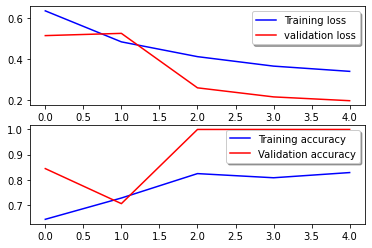

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Plot the confusion matrix

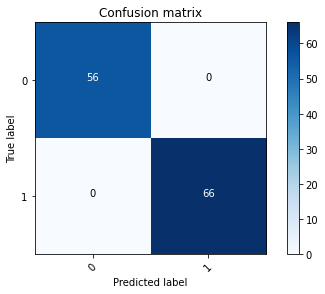

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))